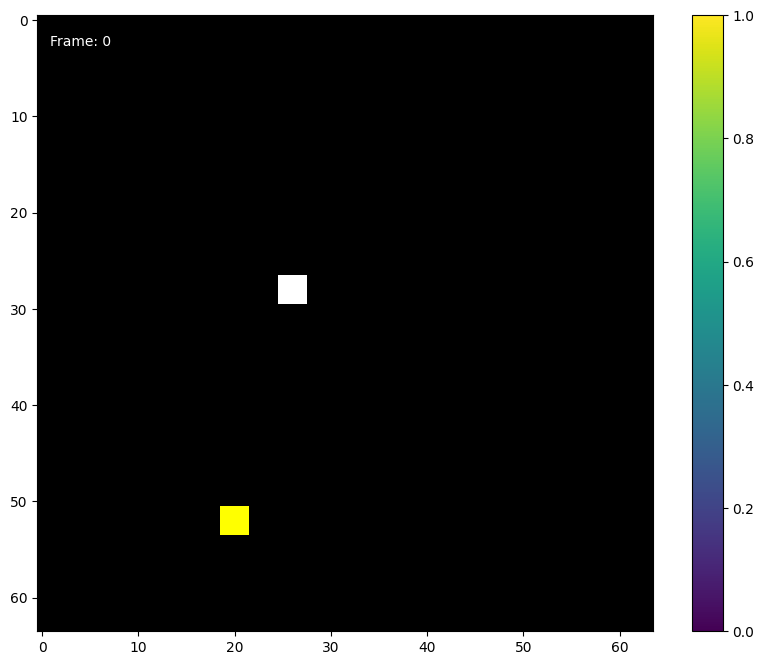

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
import ipywidgets as widgets
import glob
import os

def create_interactive_animation(directory_path):
    # Get all numpy files in the directory
    files = sorted(glob.glob(os.path.join(directory_path, '*.npy')))
    
    if not files:
        raise ValueError("No .npy files found in the specified directory")
    
    # Create figure and axis
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Load and display first image
    image = np.load(files[0])
    image = np.transpose(image, (1, 2, 0))
    img_display = ax.imshow(image)
    plt.colorbar(img_display)
    
    # Frame counter text
    frame_text = ax.text(0.02, 0.95, 'Frame: 0', transform=ax.transAxes, color='white')
    
    # Create widgets
    play_button = widgets.Play(
        value=0,
        min=0,
        max=len(files)-1,
        step=1,
        description="Play",
        interval=100
    )
    
    slider = widgets.IntSlider(
        value=0,
        min=0,
        max=len(files)-1,
        step=1,
        description='Frame:',
        continuous_update=False
    )
    
    # Link play button to slider
    widgets.jslink((play_button, 'value'), (slider, 'value'))
    
    def update(change):
        # Get the current frame number
        frame = change['new']
        
        # Load and display the image
        image = np.load(files[frame])
        image = np.transpose(image, (1, 2, 0))
        img_display.set_array(image)
        
        # Update frame counter
        frame_text.set_text(f'Frame: {frame}/{len(files)-1}')
        
        # Update display
        fig.canvas.draw_idle()
    
    # Connect the slider to the update function
    slider.observe(update, names='value')
    
    # Display widgets and plot
    controls = widgets.HBox([play_button, slider])
    display(controls)
    plt.show()

# Usage example
directory_path = "/home/rahm/TEST/IMG"
create_interactive_animation(directory_path)

In [8]:
import numpy as np

a = np.arccos(np.dot(np.array([-1,-1]), np.array([1,1]))/(np.linalg.norm(np.array([-1,-1]))*np.linalg.norm(np.array([1,1]))))

In [9]:
a

np.float64(3.1415926325163688)

In [6]:
#IMPORTS
import numpy as np
from math import hypot, sqrt
from random import randrange as rand
import cv2

#Value assignments
gui = 0             #acts as truth value if gui is open
clickCount = 0      #counts number of clicks for the double click to choose start and end points
max_dist = 20       #maximum distance between two nodes of a tree
delta_radius = 10   #radius around the end point to be determined as the finishing area

# Distance b/w two points
def dist(p1,p2):
  return hypot(p2[0]-p1[0],p2[1]-p1[1])


class Vertex:
  def __init__(self,pos,parent):
    self.pos = pos
    self.parent = parent


class RRT_star_connect :

	def __init__(self,env_image):
		print("Running...")
		print("First double click at the desired starting point, then double click at desired goal point")
		self._initPos = (-4,5)
		self._targetPos = (7,-7)
		self._map = env_image.copy()
		self._map[self._map==255] = 1
		self._height = env_image.shape[0]
		self._width = env_image.shape[1]
		self._path=[]


	def start_connect(self,env_image=None):
		"""
		Path-Planning-connect based algorithm
		"""

		goal = False
		count = 1
		self._path=[]
		newvertex=[]
		vertices=[]
		newvertex.append(Vertex(self._initPos,None))
		newvertex.append(Vertex(self._targetPos,None))
		vertices.append([newvertex[0]])
		vertices.append([newvertex[1]])

		# main loop
		while not goal:

			count = (count + 1) % 2     #to select the tree (either from the start or the one from the goal)
			# create random point
			newpoint = (rand(self._width),rand(self._height))
			nearest_dist = float('inf')
			# look for the nearest point in the tree
			for v in vertices[count]:
				curr_dist = dist(newpoint,v.pos)
				if curr_dist < nearest_dist:
					nearest = v
					nearest_dist = curr_dist

			newpoint=self.steer(nearest.pos,newpoint)

			# try to connect the point to the tree
			if not self.collide_line(nearest.pos,newpoint):
				newvertex[count] = Vertex(newpoint,nearest)
				vertices[count].append(newvertex[count])

				if gui:
					if count % 2 == 0:
						env_image=cv2.circle(env_image,newpoint,2,(255,0,0),-1)
						env_image=cv2.line(env_image,newpoint,nearest.pos,(255,0,0),1)
					else:
						env_image=cv2.circle(env_image,newpoint,2,(255,125,0),-1)
						env_image=cv2.line(env_image,newpoint,nearest.pos,(255,125,0),1)
					cv2.imshow('Path-Planning', env_image)
					cv2.waitKey(10)

				# try to connect the point to the other tree
				nearest_dist = float('inf')
				for v in vertices[(count+1)%2]:
					curr_dist = dist(newpoint,v.pos)
					if curr_dist < nearest_dist:
						nearest = v
						nearest_dist = curr_dist


				newpoint=self.steer(nearest.pos,newpoint)

				#connecting point to tree
				if not self.collide_line(newpoint,nearest.pos):
					#checking if goal reached
					if newpoint == vertices[count][-1].pos:
						goal = True
					else:
						newvertex[(count+1)%2] = Vertex(newpoint,nearest)
						vertices[(count+1)%2].append(newvertex[(count+1)%2])
						if gui:
							env_image=cv2.circle(env_image,newpoint,2,(255,120,0),-1)
							env_image=cv2.line(env_image,newpoint,nearest.pos,(255,120,0),1)
							cv2.imshow('Path-Planning', env_image)
							cv2.waitKey(10)

		#path building
		self._path =[]

		if count == 0:
			currentvertex1 = newvertex[count]
			currentvertex2 = nearest
		else:
			currentvertex1 = nearest
			currentvertex2 = newvertex[count]

		while currentvertex1.parent:
			self._path.append(currentvertex1.pos)
			currentvertex1 = currentvertex1.parent
		self._path.append(currentvertex1.pos)
		self._path.reverse()
		while currentvertex2.parent:
			self._path.append(currentvertex2.pos)
			currentvertex2 = currentvertex2.parent
		self._path.append(currentvertex2.pos)

		self.shorten_path()

		if gui:
			self.draw_path(env_image)

	def shorten_path(self):
		'''
		Shortening path (star)
		'''
		path=self._path[:]
		self._path=[]
		self._path.append(path[0])
		i = 0
		j = i + 2
		while j < len(path):
			if self.collide_line(path[i],path[j]):
				self._path.append(path[j-1])
				i = j-1
			j += 1
		self._path.append(path[j-1])


	def draw_path(self,env_image):
		"""
		Generating red path
		"""
		for i in range(1,len(self._path)):
			env_image=cv2.line(env_image,self._path[i-1],self._path[i],(0,0,255),4)
			cv2.imshow('Path-Planning', env_image)
			cv2.waitKey(10)


	def steer(self,startpoint,directedpoint):
		if dist(startpoint,directedpoint)<max_dist:
			return directedpoint
		else:
			d = sqrt((directedpoint[1]-startpoint[1])*(directedpoint[1]-startpoint[1])+(directedpoint[0]-startpoint[0])*(directedpoint[0]-startpoint[0]))
			return (int(startpoint[0]+max_dist/d*(directedpoint[0]-startpoint[0])),int(startpoint[1]+max_dist/d*(directedpoint[1]-startpoint[1])))


	def collide_line(self,start,end):
		"""
		Checking path feasibility
		"""
		img = np.zeros((self._height,self._width))
		img = cv2.line(img,start,end,1,1)
		intersection = np.logical_and( self._map, img)
		if np.count_nonzero(intersection)==0:
			return False
		else:
			return True

	def collide_circle(self,point,radius):
		"""
		Checking point feasibility
		"""
		img = np.zeros((self._height,self._width))
		img = cv2.circle(img,point,radius,1,-1)
		intersection = np.logical_and( self._map, img)
		if np.count_nonzero(intersection)==0:
			return False
		else:
			return True


	def test_goal(self,point):
		"""
		If target point is reached (with some delta error)
		"""
		if (self._targetPos[0]-delta_radius<point[0]<self._targetPos[0]+delta_radius) and (self._targetPos[1]-delta_radius<point[1]<self._targetPos[1]+delta_radius):
			return True
		else:
			return False

	'''
	mouse clicking function
	for selecting start and end points
	'''
	def pos_define(self,event,x,y,flags,param):
		global clickCount
		if event == cv2.EVENT_LBUTTONDBLCLK:
			if not self.collide_circle((x,y),delta_radius):
				if clickCount==0:
					self._initPos = (x,y)
					param=cv2.circle(param,(x,y),delta_radius,(0,255,0),-1)
				if clickCount==1:
					self._targetPos = (x,y)
					param=cv2.circle(param,(x,y),delta_radius,(0,0,255),-1)
				clickCount +=1


if __name__ == '__main__':
	env_image = cv2.imread("/home/rahm/.local/share/ov/pkg/isaac-sim-4.2.0/standalone_examples/api/omni.isaac.kit/MAIN_FILES/WR_World.png",1)
	loaded_env= cv2.cvtColor(env_image,cv2.COLOR_BGR2GRAY)
	ret,loaded_env = cv2.threshold(loaded_env,175,255,cv2.THRESH_BINARY)

	rrt = RRT_star_connect(env_image=loaded_env)


	

	#deciding start and goal point (using double click)
	if gui:
		cv2.imshow('Path-Planning', env_image)
		cv2.setMouseCallback('Path-Planning',rrt.pos_define, param=env_image)
		while(clickCount<2):
			cv2.imshow('Path-Planning', env_image)
			if cv2.waitKey(20) & 0xFF == 27:
				break
		rrt.start_connect(env_image)

	if gui:
		while(1):
			cv2.imshow('Path-Planning', env_image)
			if cv2.waitKey(10) & 0xFF == 27:
				break
		cv2.destroyAllWindows()
	print("quit")

Running...
First double click at the desired starting point, then double click at desired goal point
quit


Planning path...
No path found!


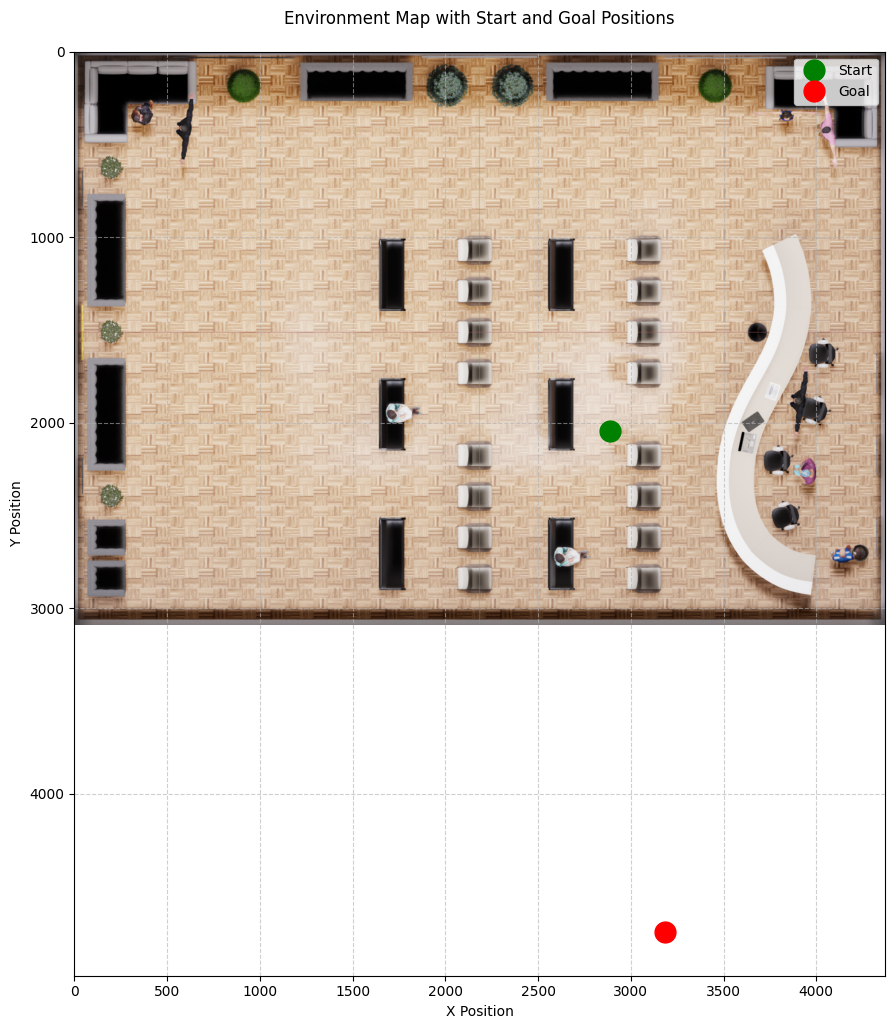

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from RRTStar import BidirectionalRRTStarPlanner

def visualize_map_and_path(image_path, start, goal, path=None):
    # Load the image
    img = plt.imread(image_path)
    height, width = img.shape[:2]
    
    # Create figure and axis
    fig, ax = plt.subplots(figsize=(12, 12))
    
    # Show the image
    ax.imshow(img, cmap='gray')
    
    # Plot start and goal
    start_x, start_y = start[0] + width/2, start[1] + height/2
    goal_x, goal_y = goal[0] + width/2, goal[1] + height/2
    
    ax.plot(start_x, start_y, 'go', markersize=15, label='Start')
    ax.plot(goal_x, goal_y, 'ro', markersize=15, label='Goal')
    
    # Plot path if it exists
    if path is not None:
        path_x = path[:, 0] + width/2
        path_y = path[:, 1] + height/2
        ax.plot(path_x, path_y, 'b-', linewidth=2, label='Path')
    
    # Add grid
    ax.grid(True, linestyle='--', alpha=0.6)
    
    # Add title and labels
    ax.set_title('Environment Map with Start and Goal Positions', pad=20)
    ax.set_xlabel('X Position')
    ax.set_ylabel('Y Position')
    
    # Add legend
    ax.legend()
    
    plt.show()

if __name__ == "__main__":
    # Test the planner
    image_path = "/home/rahm/.local/share/ov/pkg/isaac-sim-4.2.0/standalone_examples/api/omni.isaac.kit/MAIN_FILES/WR_World.png"
    planner = BidirectionalRRTStarPlanner(
        image_path,
        max_iter=2000,
        step_size=1.0,
        search_radius=3.0,
        goal_sample_rate=0.1
    )
    
    start = np.array([700.0, 500.0])
    goal = np.array([1000.0, 3200.0])
    
    print("Planning path...")
    result = planner.plan(start, goal)
    
    if result:
        print(f"Path found in {result['time']:.2f} seconds")
        print(f"Path cost: {result['cost']:.2f}")
        visualize_map_and_path(image_path, start, goal, result['path'])
    else:
        print("No path found!")
        visualize_map_and_path(image_path, start, goal)